In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from scipy.io import wavfile

from tensorflow.keras.models import *

In [2]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, win=128):
        self.fs, self.data = wavfile.read(filename)
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def x(self):
        spec  = fwd_spectrogram(self.data, win=512 + 2 * highpass)[:, 0:256] 
        t, d = spec.shape
        for i in range(self.win, t, self.win // 10):
            x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
            mu     = np.mean(x)
            std    = np.std(x) + 1.0
            window = (x - mu) / std
            yield window
            
def fwd_spectrogram(audio, win=512, step=64):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2        
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [15]:
import sys
sys.path.append("../ml") 

from train_lstm_auto_encoder_variational import VAE

models = '../models/lstm_v4/v4.2/'
vae = VAE()
vae.auto_encoder((128, 256, 1), 128, 256 * 128, 128)
ae  = vae.model
encoder = vae.encoder 
ae.load_weights('{}autoencoder.h5'.format(models))
encoder.load_weights('{}encoder.h5'.format(models))
encoder.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 256 16640       input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 1, 256)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 128, 256)     0           max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [16]:
#PATH = '../data/catalogue/whistle_snippets/'
#encoder = load_model('../models/lstm_v4/v4.2/encoder.h5')
latent = []
for file in os.listdir(PATH):
    if file.endswith('.wav'):
        p = "{}{}".format(PATH, file)
        spec = StreamSpectrogram(p)
        x = [x for x in spec.x()]
        if len(x) > 0:
            latent.append([encoder.predict(np.stack(x)), spec.data])
            print(latent[-1][0].shape)

(1, 128)
(9, 128)
(22, 128)
(2, 128)
(5, 128)
(3, 128)
(25, 128)
(1, 128)
(4, 128)
(49, 128)
(66, 128)
(22, 128)
(3, 128)
(30, 128)
(10, 128)
(11, 128)
(7, 128)
(1, 128)
(11, 128)
(16, 128)
(12, 128)
(2, 128)
(69, 128)
(49, 128)
(8, 128)
(8, 128)
(12, 128)
(6, 128)
(7, 128)
(6, 128)
(1, 128)
(1, 128)
(9, 128)
(30, 128)
(9, 128)
(2, 128)


In [17]:
import pickle
pickle.dump( latent, open( "data.p", "wb" ) )

In [18]:
%load_ext Cython

In [19]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef int w = max(round((n + m) / 4), abs(n - m) + 2)
    
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(max(1, i-w), min(m + 1, i+w)):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                10 + dp[i - 1][j    ],
                10 + dp[i    ][j - 1]
            )
    if np.isinf(dp[n][m]):
        print('\t\tERROR: inf in warping')
    return dp[n][m] / (n + m)

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

36
0 / 36
10 / 36
20 / 36
30 / 36


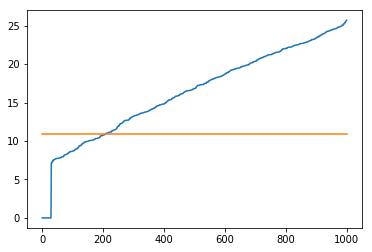

10.856941922505696


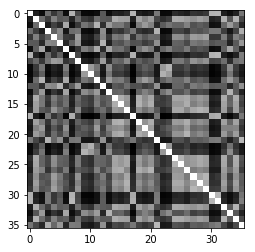

In [20]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 20)

plt.plot(sorted(f[0:1000]))
plt.plot(np.ones(1000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]

plt.imshow(np.mean(distances) - distances, cmap='gray')
plt.show()

In [21]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [22]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [23]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='average', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [24]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    c[cluster_id].append(latent[i][1])

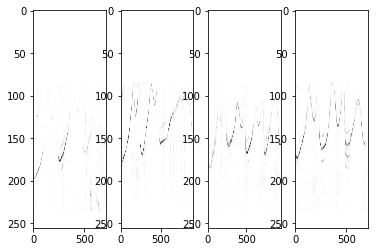

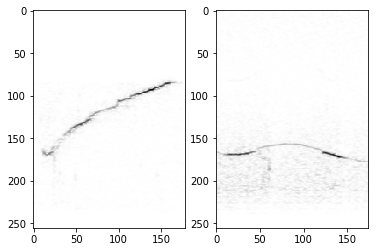

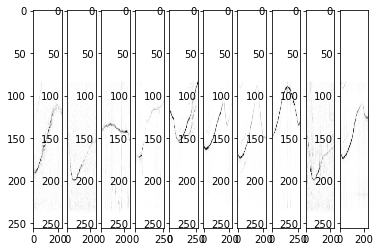

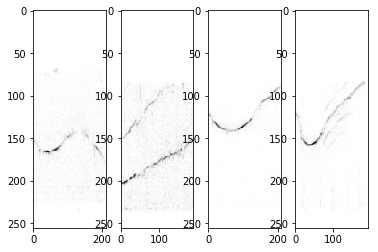

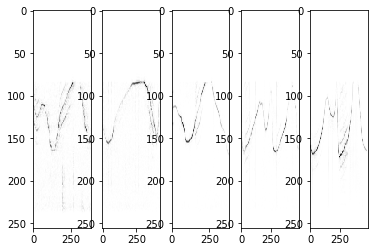

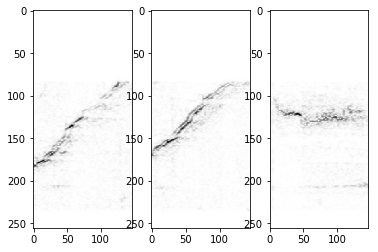

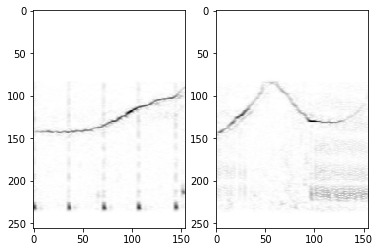

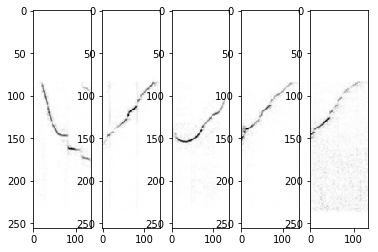

In [25]:
for cid, x in enumerate(c):
    if len(x) > 1:
        for i, a in enumerate(x):
            plt.subplot(1, len(x), i + 1)
            spec = fwd_spectrogram(a)
            plt.imshow(1.0 - spec.T, cmap='gray', aspect='auto')
        plt.savefig('{}.png'.format(cid))
        plt.show()
